In [106]:
health_data = read.csv("health_data.csv")
set.seed(1234)
library(dplyr)
library(tidyr)
library(ggplot2)
library(GGally)
library(fastDummies)
library(reshape2)
library(randomForest)
library(ranger)
library(caret)
library(pROC)
library(nnet)
library(speedglm)

In [107]:
health_data$Diabetes <- as.factor(health_data$Diabetes)

health_data= health_data %>% separate(BloodPressure, c("BloodPressureNumerator","BloodPressureDenominator"),"/")

health_data$`BloodPressureNumerator` <- as.numeric(as.character(health_data$`BloodPressureNumerator`))
health_data$`BloodPressureDenominator` <- as.numeric(as.character(health_data$`BloodPressureDenominator`))

In [108]:
health_data_diabetes = health_data

In [109]:
head(health_data_diabetes)

,PatientID,Age,Gender,BMI,SmokingStatus,AlcoholConsumption,ExerciseFrequency,CholesterolLevel,BloodPressureNumerator,BloodPressureDenominator,Diabetes,HeartDisease,PhysicalActivityLevel,DietQuality,MedicationAdherence,AnnualCheckups,GeneticRisk,HealthcareCost,Outcome
,<int>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
1,1,82,Male,27.72798,Never,Never,Never,170.5041,124,80,No,Yes,Low,Average,Medium,2,0.89,20974.84,Healthy
2,2,62,Female,26.12258,Former,Never,Sometimes,183.7046,155,75,Yes,No,Low,Good,Medium,1,0.95,12693.40,Healthy
3,3,26,Female,37.61520,Never,Occasionally,Never,256.5829,100,96,No,No,Medium,Average,High,1,1.00,13103.52,Critical
4,4,64,Male,33.12029,Current,Never,Sometimes,163.4861,159,82,No,No,Medium,Average,Medium,3,1.00,15920.20,Healthy
5,5,34,Female,30.66780,Never,Regularly,Sometimes,247.2195,131,80,No,No,Medium,Average,High,4,1.00,18529.89,Critical
6,6,34,Male,28.12764,Never,Never,Sometimes,173.1878,144,93,Yes,No,Medium,Poor,Medium,3,0.97,12930.51,Healthy


In [110]:
health_data_diabetes$Gender = factor(health_data_diabetes$Gender,level = c('Male','Female',"Other"))
health_data_diabetes$SmokingStatus = factor(health_data_diabetes$SmokingStatus,levels = c('Never','Former','Current'))
health_data_diabetes$AlcoholConsumption = factor(health_data_diabetes$AlcoholConsumption,levels = c('Never','Occasionally','Regularly'))
health_data_diabetes$ExerciseFrequency = factor(health_data_diabetes$ExerciseFrequency,levels = c('Never','Sometimes','Often','Rarely'))
health_data_diabetes$PhysicalActivityLevel = factor(health_data_diabetes$PhysicalActivityLevel,levels = c('Low','Medium','High'))
health_data_diabetes$DietQuality = factor(health_data_diabetes$DietQuality,levels = c('Average','Good','Poor'))
health_data_diabetes$MedicationAdherence = factor(health_data_diabetes$MedicationAdherence,levels = c('Medium','High','Low'))
health_data_diabetes$Outcome = factor(health_data_diabetes$Outcome,levels = c('Healthy','Critical','At Risk'))
health_data_diabetes$Diabetes <- as.factor(health_data_diabetes$Diabetes)
#health_data_diabetes$num_blood_p_ln = log(health_data_diabetes$BloodPressureNumerator)
#health_data_diabetes$num_blood_n_ln = log(health_data_diabetes$BloodPressureDenominator)
# health_data_diabetes$CholesterolLevel_ln = log(health_data_diabetes$CholesterolLevel)
# health_data_diabetes$BMI_ln = log(health_data_diabetes$BMI)
#health_data_diabetes$blod_pressure_div = health_data_diabetes$BloodPressureNumerator / health_data_diabetes$BloodPressureDenominator

health_data_diabetes=dummy_cols(health_data_diabetes,select_columns = c("Gender","SmokingStatus","AlcoholConsumption","ExerciseFrequency","HeartDisease","PhysicalActivityLevel","DietQuality","MedicationAdherence","Outcome"))
health_data_diabetes = subset(health_data_diabetes, select=-c(Gender,SmokingStatus,AlcoholConsumption,ExerciseFrequency,HeartDisease,PhysicalActivityLevel,DietQuality,MedicationAdherence,Outcome,PatientID))
names(health_data_diabetes)[names(health_data_diabetes) == 'Outcome_At Risk'] <- 'Outcome_at_risk'

In [111]:
health_data_diabetes$id <- 1:nrow(health_data)
train <- health_data_diabetes %>% dplyr::sample_frac(0.80)
test  <- dplyr::anti_join(health_data_diabetes, train, by = 'id')

In [112]:
train <- subset(train, select = -c(id))

In [113]:
nrow(train)

[1] 240000

In [114]:
rand_forest_log_diabetes <- ranger(
  Diabetes ~ ., 
  data = train, mtry = 3, 
  num.trees = 100, 
  probability = TRUE, 
  importance = 'impurity'
)
print(rand_forest_log_diabetes)

Ranger result

Call:
 ranger(Diabetes ~ ., data = train, mtry = 3, num.trees = 100,      probability = TRUE, importance = "impurity") 

Type:                             Probability estimation 
Number of trees:                  100 
Sample size:                      240000 
Number of independent variables:  35 
Mtry:                             3 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.1290632 


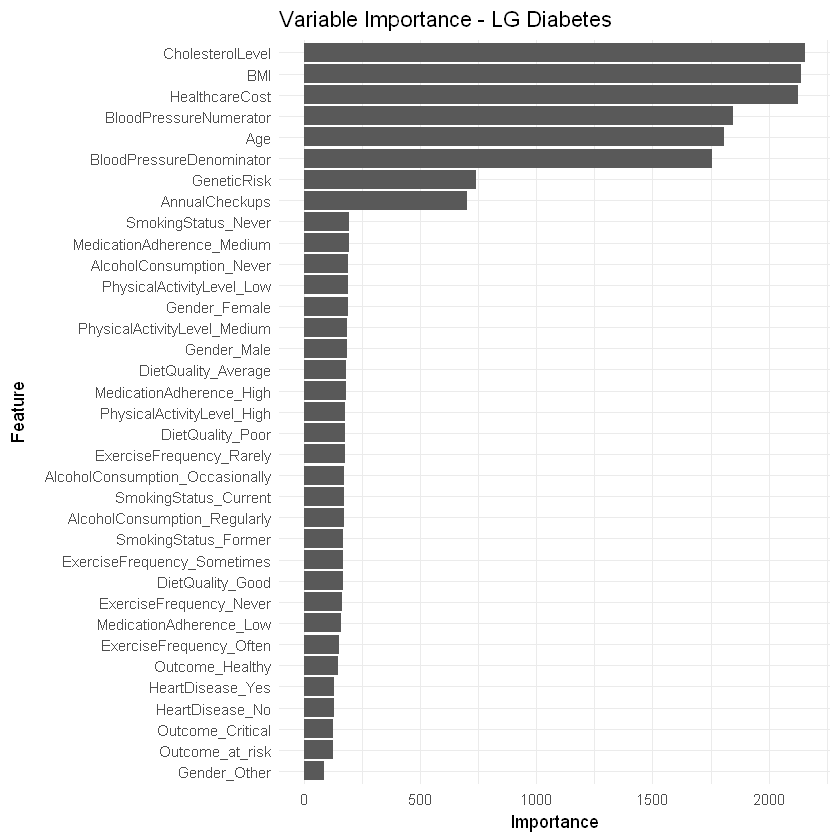

In [115]:
importance_scores_diabetes = rand_forest_log_diabetes$variable.importance
important_vars_df_log_diabetes = data.frame(Variables = names(importance_scores_diabetes),Score= importance_scores_diabetes)

ggplot(important_vars_df_log_diabetes, aes(x = reorder(Variables, Score), y = Score)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance - LG Diabetes",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

In [184]:
predictions_diabetes <- predict(rand_forest_log_diabetes, 
                                    data = dplyr::select(test, -Diabetes))$predictions
predictions_diabetes <- as.data.frame(predictions_diabetes)

predictions_diabetes <- predictions_diabetes %>%
  mutate(Pred = ifelse(No > 0.8, 0, 1))

actual_diabetes <- ifelse(test$Diabetes == "No", 0, 1)

In [185]:
actual_factor_diabetes <- factor(actual_diabetes)

conf_matrix <- confusionMatrix(as.factor(predictions_diabetes$Pred), actual_factor_diabetes)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 49508  8703
         1  1534   255
                                          
               Accuracy : 0.8294          
                 95% CI : (0.8263, 0.8324)
    No Information Rate : 0.8507          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.0024         
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.96995         
            Specificity : 0.02847         
         Pos Pred Value : 0.85049         
         Neg Pred Value : 0.14254         
             Prevalence : 0.85070         
         Detection Rate : 0.82513         
   Detection Prevalence : 0.97018         
      Balanced Accuracy : 0.49921         
                                          
       'Positive' Class : 0               
                  

In [192]:
actual_diabetes

[1] 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0
   [37] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0
   [73] 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0
  [109] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
  [145] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0
  [181] 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
  [217] 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  [253] 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0
  [289] 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
  [325] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [361] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  [397] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
  [433] 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  [469] 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0
  [505] 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  [541] 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  [577] 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  [613] 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1
  [649] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
  [685] 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
  [721] 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
  [757] 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  [793] 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0
  [829] 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
  [865] 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [901] 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
  [937] 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1
  [973] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1009] 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 [1045] 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 [1081] 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [1117] 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 [1153] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 [1189] 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 [1225] 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0
 [1261] 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 [1297] 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0
 [1333] 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 [1369] 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 [1405] 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1441] 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 [1477] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1513] 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0
 [1549] 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0
 [1585] 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 [1621] 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 [1657] 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 [1693] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 [1729] 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 [1765] 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 [18

Area under the curve (AUC): 0.501

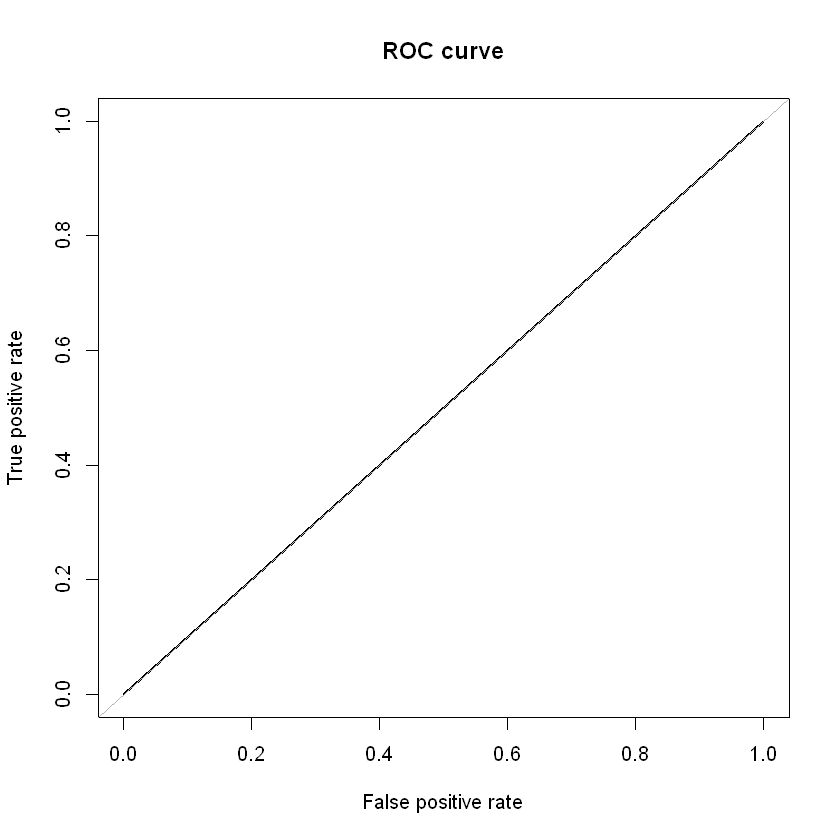

In [193]:
roc.curve(actual_diabetes,predictions_diabetes$Pred)

Decision Tree

In [194]:
library(glmtree)
library(rpart)
library(rpart.plot)

In [195]:
head(train$Diabetes)

[1] No  No  No  Yes No  No 
Levels: No Yes

In [196]:
weight <- ifelse(train$Diabetes == "No", 15, 85)
weight <- as.numeric(unlist(weight))

In [197]:
str(weight)

 num [1:240000] 15 15 15 85 15 15 15 15 15 15 ...


In [198]:
loss_matrix <- matrix(c(0, 2, 5, 0), nrow = 2, byrow = TRUE)

Warning message:
"labs do not fit even at cex 0.15, there may be some overplotting"


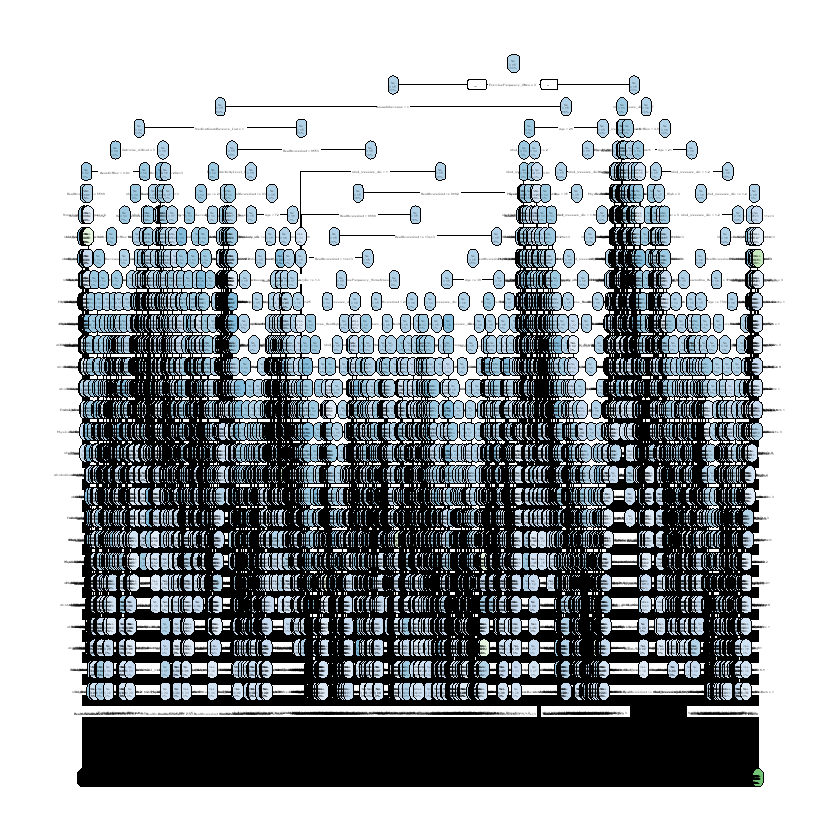

In [200]:
tree_mod <- rpart(
  Diabetes ~ ., 
  method = "class",
  data = train,
  control = rpart.control(cp = 0.00001, minsplit = 20, maxdepth = 30),  
  parms = list(loss = loss_matrix, split = "gini")  
)

rpart.plot(tree_mod)

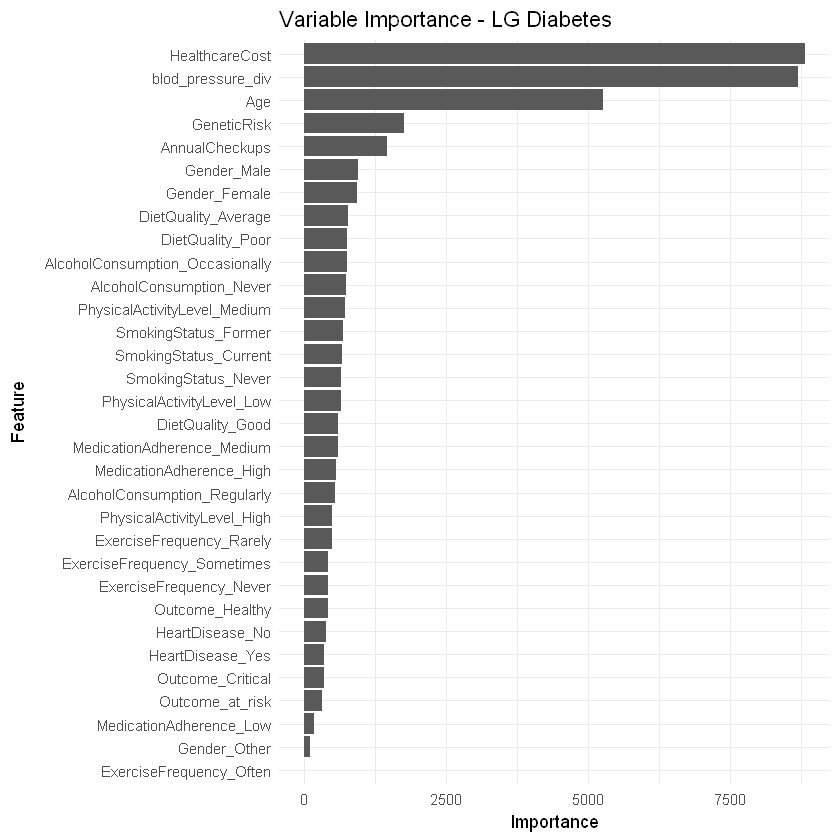

In [201]:
importance_scores_diabetes = tree_mod$variable.importance
important_vars_df_log_diabetes = data.frame(Variables = names(importance_scores_diabetes),Score= importance_scores_diabetes)

ggplot(important_vars_df_log_diabetes, aes(x = reorder(Variables, Score), y = Score)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance - LG Diabetes",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

In [202]:
tree_pred <- predict(tree_mod, test, type = "prob")
head(tree_pred)

tree_pred = as.data.frame(tree_pred)

,No,Yes
1,0.9135802,0.08641975
2,0.9130435,0.08695652
3,0.9375000,0.06250000
4,0.8365299,0.16347005
5,0.4285714,0.57142857
6,0.6800000,0.32000000


In [209]:

tree_pred <- tree_pred %>%
  mutate(Pred = ifelse(No > 0.8, "No", "Yes"))


In [210]:
conf_matrix <- confusionMatrix(as.factor(tree_pred$Pred), as.factor(test$Diabetes))
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction    No   Yes
       No  40594  7117
       Yes 10448  1841
                                          
               Accuracy : 0.7072          
                 95% CI : (0.7036, 0.7109)
    No Information Rate : 0.8507          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 7e-04           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7953          
            Specificity : 0.2055          
         Pos Pred Value : 0.8508          
         Neg Pred Value : 0.1498          
             Prevalence : 0.8507          
         Detection Rate : 0.6766          
   Detection Prevalence : 0.7952          
      Balanced Accuracy : 0.5004          
                                          
       'Positive' Class : No              
                  

Area under the curve (AUC): 0.500

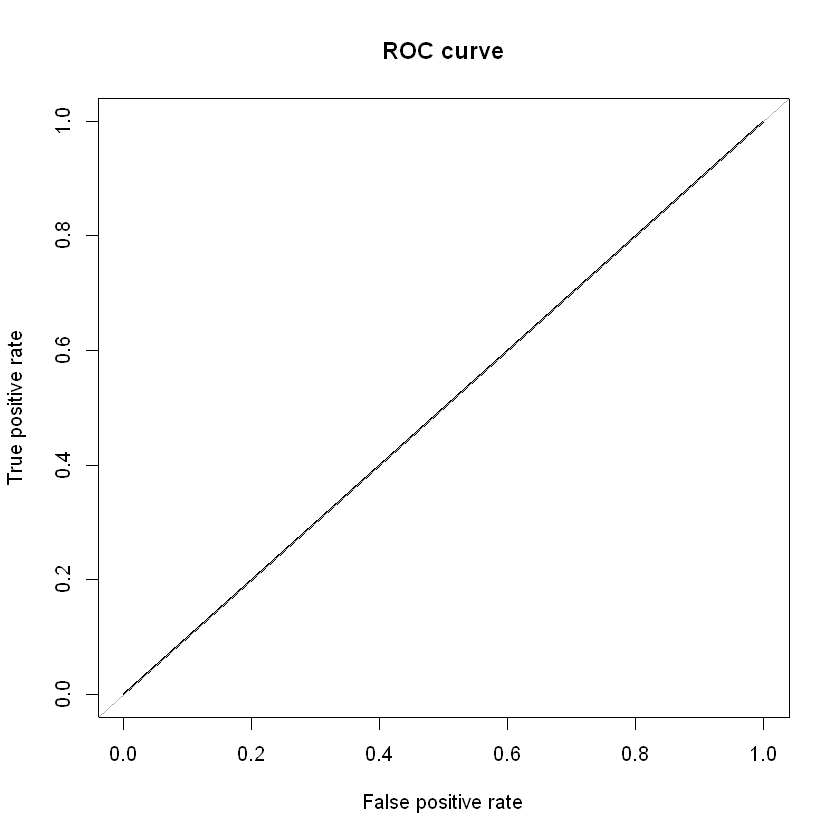

In [212]:
roc.curve(test$Diabetes,tree_pred$Pred)

[1] 0.7215167

oversample

In [213]:
library(penalizedclr)
set.seed(1234)
library(ROSE)

In [215]:
(table(train$Diabetes))


    No    Yes 
203919  36081 

In [216]:
203919 + 36081

[1] 240000

In [217]:
data_balanced_over <- ovun.sample(Diabetes ~ ., data = train, method = "over",N=500000)$data

In [218]:
prop.table(table(data_balanced_over$Diabetes))


      No      Yes 
0.407838 0.592162 

In [219]:
over_sample_model =rpart(Diabetes~.,data = data_balanced_over, method = "class",control = rpart.control(cp = 0.00001, minsplit = 20, maxdepth = 30))

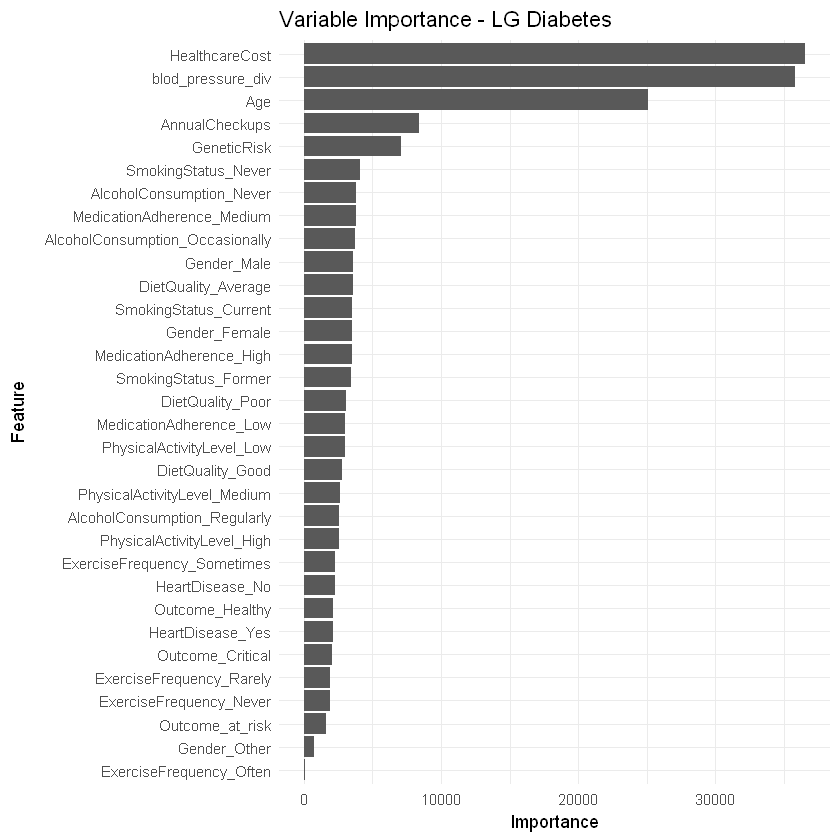

In [220]:
importance_scores_diabetes_over_sample = over_sample_model$variable.importance
important_vars_df_diabetes_over_sample = data.frame(Variables = names(importance_scores_diabetes_over_sample),Score= importance_scores_diabetes_over_sample)

ggplot(important_vars_df_diabetes_over_sample, aes(x = reorder(Variables, Score), y = Score)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance - LG Diabetes",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

In [221]:
results = predict(over_sample_model, newdata = test)

In [222]:
results_df <- as.data.frame(results)

predictions_diabetes <- results_df %>%
  mutate(Pred = ifelse(Yes > 0.8, 1, 0))


actual_diabetes <- ifelse(test$Diabetes == "No", 0, 1)

actual_factor_diabetes <- factor(actual_diabetes)


conf_matrix <- confusionMatrix(as.factor(predictions_diabetes$Pred), actual_factor_diabetes)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 42928  7497
         1  8114  1461
                                          
               Accuracy : 0.7398          
                 95% CI : (0.7363, 0.7433)
    No Information Rate : 0.8507          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.004           
                                          
 Mcnemar's Test P-Value : 8.214e-07       
                                          
            Sensitivity : 0.8410          
            Specificity : 0.1631          
         Pos Pred Value : 0.8513          
         Neg Pred Value : 0.1526          
             Prevalence : 0.8507          
         Detection Rate : 0.7155          
   Detection Prevalence : 0.8404          
      Balanced Accuracy : 0.5021          
                                          
       'Positive' Class : 0               
                  

Area under the curve (AUC): 0.502

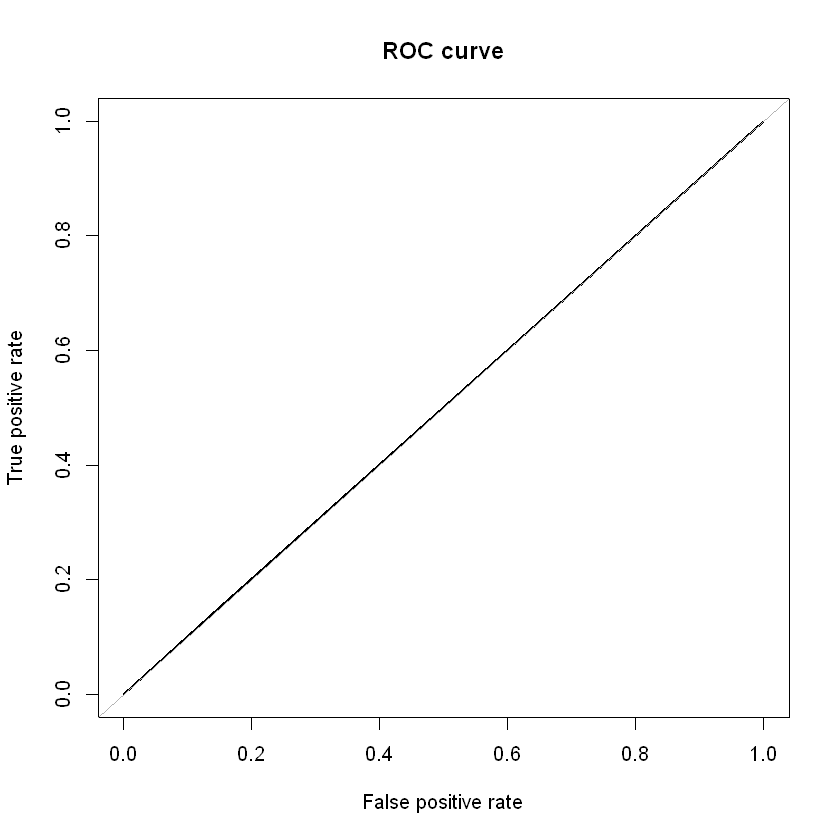

In [226]:
roc.curve(as.factor(predictions_diabetes$Pred), actual_factor_diabetes)

In [170]:
data_balanced_both <- ovun.sample(Diabetes ~ ., data = train, 
method = "both", p=0.5, N=500000, seed = 1)$data

table(data_balanced_both$Diabetes)


    No    Yes 
249890 250110 

In [171]:
both_model =rpart(Diabetes~.,data = data_balanced_both, method = "class",control = rpart.control(cp = 0.00001, minsplit = 20, maxdepth = 30))

In [172]:
results_both = predict(both_model, newdata = test)

In [173]:
results_both_df <- as.data.frame(results_both)

predictions_diabetes_both <- results_both_df %>%
  mutate(Pred = ifelse(Yes > 0.8, 1, 0))


actual_diabetes <- ifelse(test$Diabetes == "No", 0, 1)

actual_factor_diabetes <- factor(actual_diabetes)


conf_matrix_both <- confusionMatrix(as.factor(predictions_diabetes_both$Pred), actual_factor_diabetes)

print(conf_matrix_both)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 42444  7445
         1  8598  1513
                                          
               Accuracy : 0.7326          
                 95% CI : (0.7291, 0.7362)
    No Information Rate : 0.8507          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 4e-04           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8316          
            Specificity : 0.1689          
         Pos Pred Value : 0.8508          
         Neg Pred Value : 0.1496          
             Prevalence : 0.8507          
         Detection Rate : 0.7074          
   Detection Prevalence : 0.8315          
      Balanced Accuracy : 0.5002          
                                          
       'Positive' Class : 0               
                  

More Testing

In [168]:
health_data_1 = health_data

In [169]:
health_data_1$Gender = factor(health_data_1$Gender,level = c('Male','Female',"Other"))
health_data_1$SmokingStatus = factor(health_data_1$SmokingStatus,levels = c('Never','Former','Current'))
health_data_1$AlcoholConsumption = factor(health_data_1$AlcoholConsumption,levels = c('Never','Occasionally','Regularly'))
health_data_1$ExerciseFrequency = factor(health_data_1$ExerciseFrequency,levels = c('Never','Sometimes','Often','Rarely'))
health_data_1$PhysicalActivityLevel = factor(health_data_1$PhysicalActivityLevel,levels = c('Low','Medium','High'))
health_data_1$DietQuality = factor(health_data_1$DietQuality,levels = c('Average','Good','Poor'))
health_data_1$MedicationAdherence = factor(health_data_1$MedicationAdherence,levels = c('Medium','High','Low'))
health_data_1$Outcome = factor(health_data_1$Outcome,levels = c('Healthy','Critical','At Risk'))
health_data_1$Diabetes <- as.factor(health_data_1$Diabetes)
#health_data_1$blod_pressure_div = health_data_1$BloodPressureNumerator / health_data_1$BloodPressureDenominator


In [170]:
health_data_1=dummy_cols(health_data_1,select_columns = c("Gender","SmokingStatus","AlcoholConsumption","ExerciseFrequency","HeartDisease","PhysicalActivityLevel","DietQuality","MedicationAdherence","Outcome"))

#health_data_1 = subset(health_data_1, select=-c(Gender,SmokingStatus,AlcoholConsumption,ExerciseFrequency,HeartDisease,PhysicalActivityLevel,DietQuality,MedicationAdherence,Outcome,PatientID,BloodPressureDenominator,BloodPressureNumerator))
names(health_data_1)[names(health_data_1) == 'Outcome_At Risk'] <- 'Outcome_at_risk'


In [171]:
colnames(health_data_1)

[1] "PatientID"                       "Age"                            
 [3] "Gender"                          "BMI"                            
 [5] "SmokingStatus"                   "AlcoholConsumption"             
 [7] "ExerciseFrequency"               "CholesterolLevel"               
 [9] "BloodPressureNumerator"          "BloodPressureDenominator"       
[11] "Diabetes"                        "HeartDisease"                   
[13] "PhysicalActivityLevel"           "DietQuality"                    
[15] "MedicationAdherence"             "AnnualCheckups"                 
[17] "GeneticRisk"                     "HealthcareCost"                 
[19] "Outcome"                         "Gender_Male"                    
[21] "Gender_Female"                   "Gender_Other"                   
[23] "SmokingStatus_Never"             "SmokingStatus_Former"           
[25] "SmokingStatus_Current"           "AlcoholConsumption_Never"       
[27] "AlcoholConsumption_Occasionally" "AlcoholConsumption_Regularly"   
[29] "ExerciseFrequency_Never"         "ExerciseFrequency_Sometimes"    
[31] "ExerciseFrequency_Often"         "ExerciseFrequency_Rarely"       
[33] "HeartDisease_No"                 "HeartDisease_Yes"               
[35] "PhysicalActivityLevel_Low"       "PhysicalActivityLevel_Medium"   
[37] "PhysicalActivityLevel_High"      "DietQuality_Average"            
[39] "DietQuality_Good"                "DietQuality_Poor"               
[41] "MedicationAdherence_Medium"      "MedicationAdherence_High"       
[43] "MedicationAdherence_Low"         "Outcome_Healthy"                
[45] "Outcome_Critical"                "Outcome_at_risk"

In [172]:
# health_data_1$genetic_risk_time_age = health_data_1$Age*health_data_1$GeneticRisk
# health_data_1$genetic_risk_time_age = health_data_1$AnnualCheckups*health_data_1$BMI
# health_data_1$genetic_risk_time_col= health_data_1$CholesterolLevel*health_data_1$GeneticRisk
# health_data_1$risk_times_poor_exercise = health_data_1$GeneticRisk*health_data_1$PhysicalActivityLevel_Low
health_data_1$risk_times_poor_exercise = health_data_1$BMI*health_data_1$CholesterolLevel
health_data_1$poor = health_data_1$DietQuality_Poo+health_data_1$PhysicalActivityLevel_Low+health_data_1$ExerciseFrequency_Never
health_data_1$age_healthcare = health_data_1$Age*health_data_1$HealthcareCost


In [173]:
health_data_1 = subset(health_data_1, select=-c(Gender,SmokingStatus,AlcoholConsumption,ExerciseFrequency,HeartDisease,PhysicalActivityLevel,DietQuality,MedicationAdherence,Outcome,PatientID,CholesterolLevel,BMI,DietQuality_Poor,PhysicalActivityLevel_Low,ExerciseFrequency_Never,Age,HealthcareCost))

In [174]:
colnames(health_data_1)

[1] "BloodPressureNumerator"          "BloodPressureDenominator"       
 [3] "Diabetes"                        "AnnualCheckups"                 
 [5] "GeneticRisk"                     "Gender_Male"                    
 [7] "Gender_Female"                   "Gender_Other"                   
 [9] "SmokingStatus_Never"             "SmokingStatus_Former"           
[11] "SmokingStatus_Current"           "AlcoholConsumption_Never"       
[13] "AlcoholConsumption_Occasionally" "AlcoholConsumption_Regularly"   
[15] "ExerciseFrequency_Sometimes"     "ExerciseFrequency_Often"        
[17] "ExerciseFrequency_Rarely"        "HeartDisease_No"                
[19] "HeartDisease_Yes"                "PhysicalActivityLevel_Medium"   
[21] "PhysicalActivityLevel_High"      "DietQuality_Average"            
[23] "DietQuality_Good"                "MedicationAdherence_Medium"     
[25] "MedicationAdherence_High"        "MedicationAdherence_Low"        
[27] "Outcome_Healthy"                 "Outcome_Critical"               
[29] "Outcome_at_risk"                 "risk_times_poor_exercise"       
[31] "poor"                            "age_healthcare"

In [175]:

health_data_1$id <- 1:nrow(health_data_1)
train_1 <- health_data_1 %>% dplyr::sample_frac(0.80)
test_1  <- dplyr::anti_join(health_data_1, train_1, by = 'id')

In [176]:
train_1 <- subset(train_1, select = -c(id))

In [177]:
rand_forest_log_diabetes_1 <- ranger(
  Diabetes ~ ., 
  data = train_1, mtry = 3, 
  num.trees = 100, 
  probability = TRUE, 
  importance = 'impurity'
)
print(rand_forest_log_diabetes_1)

Ranger result

Call:
 ranger(Diabetes ~ ., data = train_1, mtry = 3, num.trees = 100,      probability = TRUE, importance = "impurity") 

Type:                             Probability estimation 
Number of trees:                  100 
Sample size:                      240000 
Number of independent variables:  31 
Mtry:                             3 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.1285265 


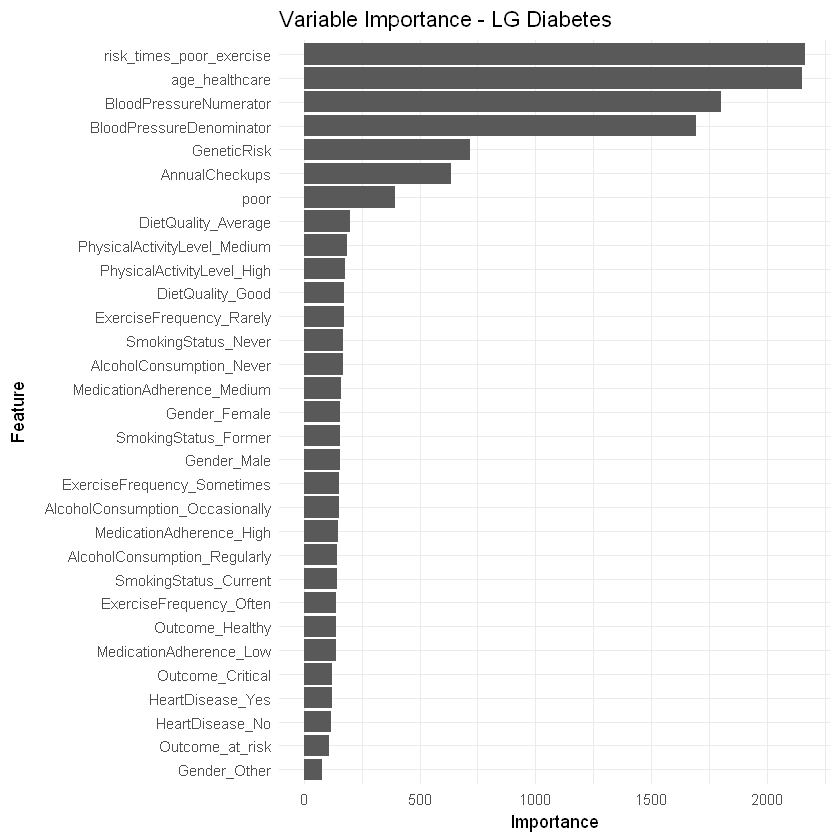

In [178]:
importance_scores_diabetes_1 = rand_forest_log_diabetes_1$variable.importance
important_vars_df_log_diabetes_1 = data.frame(Variables = names(importance_scores_diabetes_1),Score= importance_scores_diabetes_1)

ggplot(important_vars_df_log_diabetes_1, aes(x = reorder(Variables, Score), y = Score)) +
  geom_bar(stat = "identity") +
  coord_flip() +
  labs(title = "Variable Importance - LG Diabetes",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

In [179]:
predictions_diabetes_1 <- predict(rand_forest_log_diabetes_1, 
                                    data = dplyr::select(test_1, -Diabetes))$predictions
predictions_diabetes_1 <- as.data.frame(predictions_diabetes_1)

predictions_diabetes_1 <- predictions_diabetes_1 %>%
  mutate(Pred = ifelse(No > 0.8, 0, 1))


actual_diabetes_1 <- ifelse(test_1$Diabetes == "No", 0, 1)

actual_factor_diabetes_1 <- factor(actual_diabetes_1)

In [180]:
conf_matrix <- confusionMatrix(as.factor(predictions_diabetes_1$Pred), actual_factor_diabetes_1)
print(conf_matrix)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 48470  8619
         1  2470   441
                                          
               Accuracy : 0.8152          
                 95% CI : (0.8121, 0.8183)
    No Information Rate : 0.849           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 3e-04           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.95151         
            Specificity : 0.04868         
         Pos Pred Value : 0.84903         
         Neg Pred Value : 0.15149         
             Prevalence : 0.84900         
         Detection Rate : 0.80783         
   Detection Prevalence : 0.95148         
      Balanced Accuracy : 0.50009         
                                          
       'Positive' Class : 0               
                  

In [163]:
library(penalizedclr)
set.seed(1234)

library(glmtree)
library(rpart)
library(rpart.plot)
library(ROSE)

data_balanced_over_1 <- ovun.sample(Diabetes ~ ., data = train_1, method = "over",N=500000)$data

In [164]:
data_balanced_over_1

,Age,BloodPressureNumerator,BloodPressureDenominator,Diabetes,AnnualCheckups,GeneticRisk,HealthcareCost,Gender_Male,Gender_Female,Gender_Other,⋯,DietQuality_Average,DietQuality_Good,MedicationAdherence_Medium,MedicationAdherence_High,MedicationAdherence_Low,Outcome_Healthy,Outcome_Critical,Outcome_at_risk,risk_times_poor_exercise,poor
,<int>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>
1,23,147,98,No,4,1.00,15013.9435,1,0,0,⋯,0,0,1,0,0,0,0,1,6379.978,2
2,40,128,61,No,2,1.00,15838.5850,0,1,0,⋯,1,0,0,0,1,1,0,0,4574.288,0
3,50,130,112,No,0,1.00,18293.2971,0,1,0,⋯,1,0,0,1,0,0,0,1,8009.177,0
4,47,91,65,No,2,1.00,14688.9772,1,0,0,⋯,1,0,0,1,0,1,0,0,7676.794,0
5,32,159,104,No,1,0.92,7063.8362,0,1,0,⋯,0,0,0,1,0,1,0,0,6261.398,2
6,67,151,109,No,4,1.00,9737.6062,0,1,0,⋯,1,0,0,0,1,1,0,0,6504.427,0
7,38,156,119,No,4,1.00,15562.3394,1,0,0,⋯,0,0,0,1,0,1,0,0,5900.275,1
8,55,122,65,No,2,1.00,6358.5359,1,0,0,⋯,0,1,1,0,0,1,0,0,7028.028,1
9,80,109,70,No,1,0.98,13664.3227,1,0,0,⋯,1,0,1,0,0,1,0,0,8181.753,1


In [165]:
over_sample_model_1 =rpart(Diabetes~.,data = data_balanced_over_1, method = "class",control = rpart.control(cp = 0.00001, minsplit = 10, maxdepth = 15))

In [166]:
results_1 = predict(over_sample_model_1, newdata = test_1)

In [167]:
results_1_df <- as.data.frame(results_1)

predictions_diabetes_1<- results_1_df %>%
  mutate(Pred = ifelse(Yes > 0.8, 1, 0))


actual_diabetes_1 <- ifelse(test_1$Diabetes == "No", 0, 1)

actual_factor_diabetes_1 <- factor(actual_diabetes_1)


conf_matrix_2 <- confusionMatrix(as.factor(predictions_diabetes_1$Pred), actual_factor_diabetes_1)

print(conf_matrix_2)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 50036  8876
         1   924   164
                                          
               Accuracy : 0.8367          
                 95% CI : (0.8337, 0.8396)
    No Information Rate : 0.8493          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.98187         
            Specificity : 0.01814         
         Pos Pred Value : 0.84933         
         Neg Pred Value : 0.15074         
             Prevalence : 0.84933         
         Detection Rate : 0.83393         
   Detection Prevalence : 0.98187         
      Balanced Accuracy : 0.50000         
                                          
       'Positive' Class : 0               
                  